Loading CIFAR-10...
Resizing images from (32, 32) to (128, 128)...
Data ready: (2000, 128, 128, 3), Classes: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer']
Generating distorted test set...
Initializing VGG16 (Input: 128x128)...

--- Processing Shallow (Block 3) ---
  Extracting Train features...
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
  Extracting Clean Test features...
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
  Extracting Messy Test features...
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
  Training SVM...
  Accuracy Clean: 76.70%
  Accuracy Messy: 55.40%

--- Processing Deep (Block 5) ---
  Extracting Train features...
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step
  Extracting Clean Test features...
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
  Extracting Messy Test features...
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
  Training SVM...
  Accuracy Clean: 88.10%
  Accuracy Messy: 73.55%


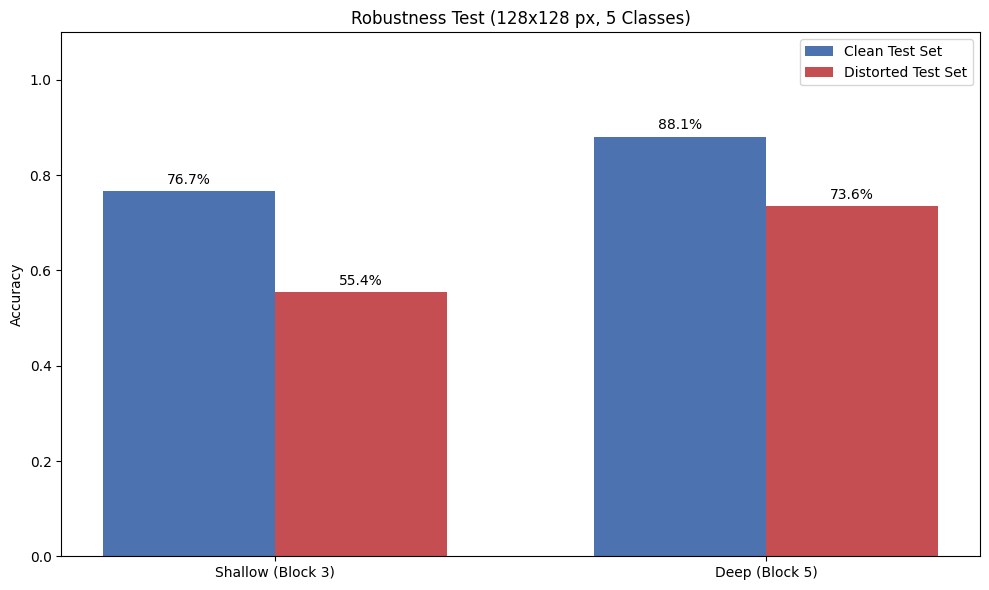

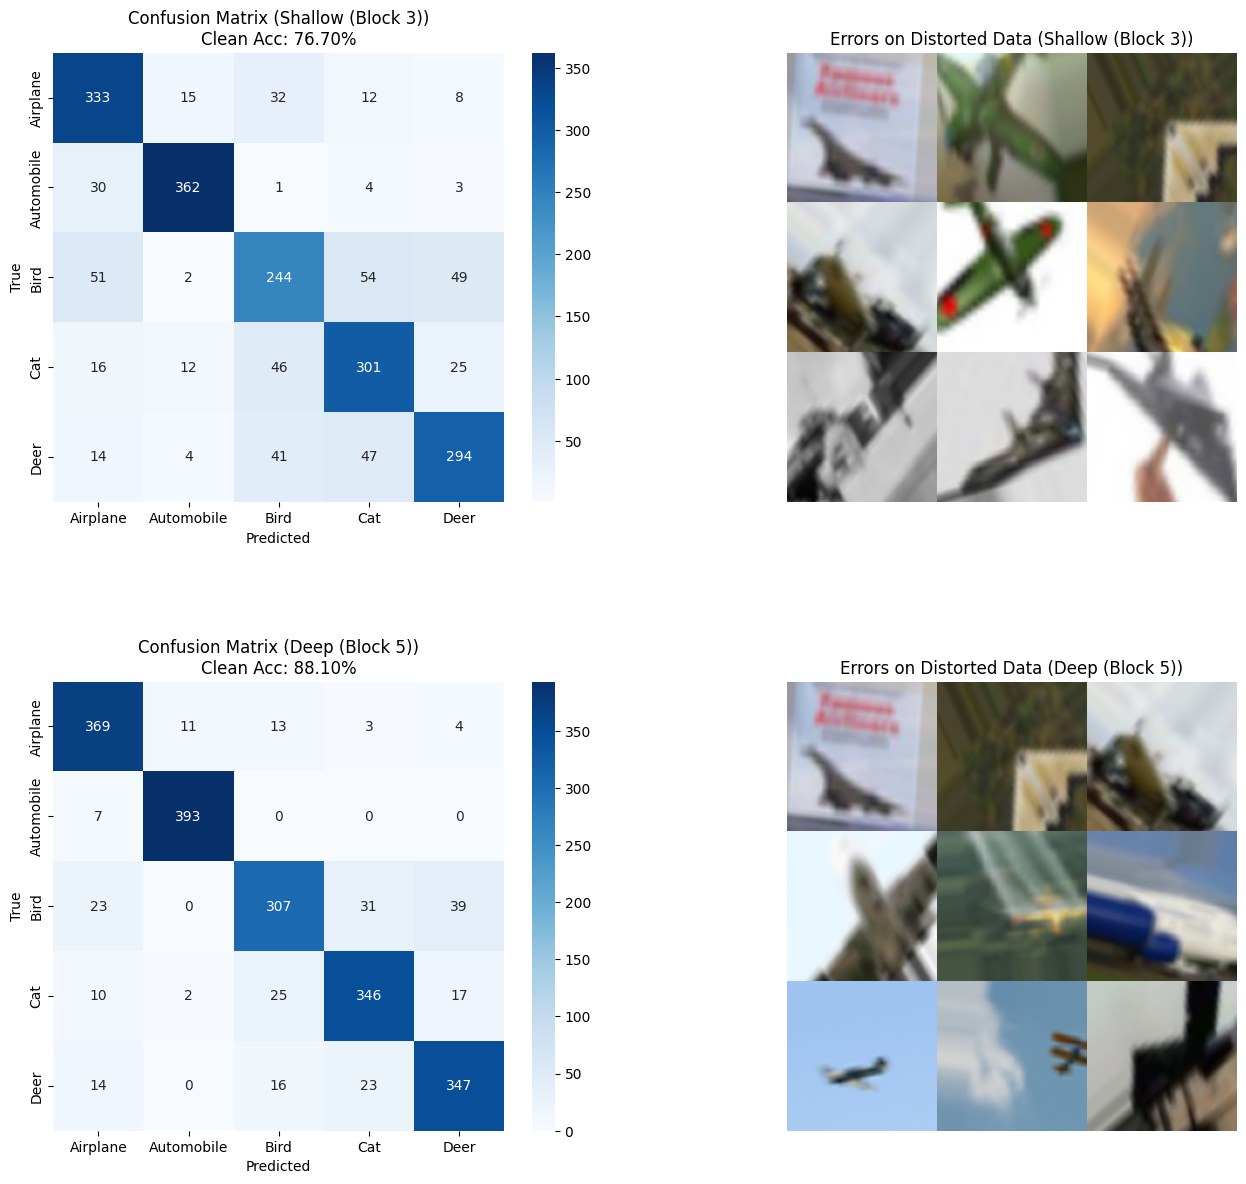

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Docker environment configuration
is_docker = '--docker' in sys.argv or os.environ.get('MPLBACKEND') == 'Agg'
if is_docker:
    plt.switch_backend('Agg')

# ==========================================
# 1. DATA PREPARATION
# ==========================================
def load_and_resize_data(classes_to_keep=[0, 1, 2, 3, 4], samples_per_class=400, target_size=(128, 128)):
    print("Loading CIFAR-10...")
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    class_names_all = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                       'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Filter data by specific classes
    def filter_data(x, y):
        keep = np.isin(y, classes_to_keep).flatten()
        x, y = x[keep], y[keep]
        x_res, y_res = [], []
        for c in classes_to_keep:
            idx = np.where(y == c)[0][:samples_per_class]
            x_res.append(x[idx])
            y_res.append(y[idx])
        return np.vstack(x_res), np.vstack(y_res)

    x_train_filt, y_train_filt = filter_data(x_train, y_train)
    x_test_filt, y_test_filt = filter_data(x_test, y_test)

    # Resize images to target dimensions
    print(f"Resizing images from (32, 32) to {target_size}...")
    x_train_resized = tf.image.resize(x_train_filt, target_size).numpy()
    x_test_resized = tf.image.resize(x_test_filt, target_size).numpy()

    selected_names = [class_names_all[i] for i in classes_to_keep]
    print(f"Data ready: {x_train_resized.shape}, Classes: {selected_names}")

    return (x_train_resized, y_train_filt), (x_test_resized, y_test_filt), selected_names

# ==========================================
# 2. DATA AUGMENTATION
# ==========================================
def create_distorted_test_set(x_data):
    print("Generating distorted test set...")
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    x_distorted = np.array([datagen.random_transform(img) for img in x_data])
    return x_distorted

# ==========================================
# 3. FEATURE EXTRACTION
# ==========================================
def extract_features(model, x_data):
    # Preprocess input for VGG16
    x = preprocess_input(x_data.copy().astype('float32'))
    features = model.predict(x, batch_size=32, verbose=1)
    return features.reshape(features.shape[0], -1)

# --- Main Execution ---
(x_train, y_train), (x_test_clean, y_test), class_names = load_and_resize_data(
    classes_to_keep=[0, 1, 2, 3, 4],
    target_size=(128, 128)
)

x_test_messy = create_distorted_test_set(x_test_clean)

print("Initializing VGG16 (Input: 128x128)...")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Define feature extractors: Deep (Block 5) vs Shallow (Block 3)
model_deep = base_model
model_shallow = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)

experiments = {
    "Shallow (Block 3)": model_shallow,
    "Deep (Block 5)": model_deep
}

results_clean = []
results_messy = []
labels = []
confusion_data = {}

for name, model in experiments.items():
    print(f"\n--- Processing {name} ---")

    # Feature extraction
    print("  Extracting Train features...")
    f_train = extract_features(model, x_train)
    print("  Extracting Clean Test features...")
    f_test_clean = extract_features(model, x_test_clean)
    print("  Extracting Messy Test features...")
    f_test_messy = extract_features(model, x_test_messy)

    # Train Classifier (SVM)
    print("  Training SVM...")
    clf = SVC(kernel='linear')
    clf.fit(f_train, y_train.ravel())

    # Evaluation
    y_pred_clean = clf.predict(f_test_clean)
    acc_clean = accuracy_score(y_test, y_pred_clean)

    y_pred_messy = clf.predict(f_test_messy)
    acc_messy = accuracy_score(y_test, y_pred_messy)

    results_clean.append(acc_clean)
    results_messy.append(acc_messy)
    labels.append(name)

    confusion_data[name] = {
        'cm': confusion_matrix(y_test, y_pred_clean),
        'acc': acc_clean,
        'y_pred_messy': y_pred_messy
    }

    print(f"  Accuracy Clean: {acc_clean:.2%}")
    print(f"  Accuracy Messy: {acc_messy:.2%}")

# ==========================================
# 4. VISUALIZATION: ROBUSTNESS
# ==========================================
x = np.arange(len(labels))
width = 0.35
fig1, ax1 = plt.subplots(figsize=(10, 6))
rects1 = ax1.bar(x - width/2, results_clean, width, label='Clean Test Set', color='#4c72b0')
rects2 = ax1.bar(x + width/2, results_messy, width, label='Distorted Test Set', color='#c44e52')

ax1.set_ylabel('Accuracy')
ax1.set_title(f'Robustness Test (128x128 px, {len(class_names)} Classes)')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylim(0, 1.1)
ax1.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.1%}', xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
if is_docker:
    plt.savefig('output_robustness.png')
    print("Saved output_robustness.png")
else:
    plt.show()

# ==========================================
# 5. VISUALIZATION: MATRICES & ERRORS
# ==========================================
fig2, axes = plt.subplots(2, 2, figsize=(16, 14))
plt.subplots_adjust(hspace=0.4)

row = 0
for name, data in confusion_data.items():
    # Confusion Matrix
    sns.heatmap(data['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[row, 0],
                xticklabels=class_names, yticklabels=class_names)
    axes[row, 0].set_title(f"Confusion Matrix ({name})\nClean Acc: {data['acc']:.2%}")
    axes[row, 0].set_ylabel('True')
    axes[row, 0].set_xlabel('Predicted')

    # Visualize Errors on Distorted Data
    y_pred = data['y_pred_messy']
    errors = np.where(y_pred != y_test.ravel())[0]

    if len(errors) > 0:
        error_idxs = errors[:9]
        collage = np.zeros((128*3, 128*3, 3), dtype=np.uint8)
        for i, idx in enumerate(error_idxs):
            r, c = i // 3, i % 3
            img = x_test_messy[idx].astype(np.uint8)
            collage[r*128:(r+1)*128, c*128:(c+1)*128, :] = img

        axes[row, 1].imshow(collage)
        axes[row, 1].set_title(f"Errors on Distorted Data ({name})")
        axes[row, 1].axis('off')

    row += 1

if is_docker:
    plt.savefig('output_matrices.png')
    print("Saved output_matrices.png")
else:
    plt.show()